In [1]:
print("MNIST Model Training")

MNIST Model Training


In [2]:
#Libraries
!pip install torchsummary
from tqdm import tqdm
from torchsummary import summary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
SEED = 10
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
device = torch.device("cuda" if cuda else "cpu")
print(device)


CUDA Available? True
cuda


Modularizing Code for Model Steps

In [4]:
class FitEvaluate:
  def __init__(self,model,device, train_loader,test_loader):
    self.model, self.device, self.train_loader, self.test_loader = model, device, train_loader,test_loader
    self.train_losses,self.test_losses, self.train_acc, self.test_acc= [], [], [], []
    pass

  def train(self, optimizer, epoch):
    try:
      self.model.train()
      pbar = tqdm(self.train_loader)
      correct = 0
      processed = 0
      for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = self.model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        self.train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        self.train_acc.append(100*correct/processed)

    except Exception as ex:
      print(f"Exception in train function: {ex}")

  def test(self):
    try:
      self.model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in self.test_loader:
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(self.test_loader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(self.test_loader.dataset),
          100. * correct / len(self.test_loader.dataset)))

      self.test_acc.append(100. * correct / len(self.test_loader.dataset))

    except Exception as ex:
        print(f"Exception in test function: {ex}")

  def plot_accuracy_loss(self):
    t = [t_items.item() for t_items in self.train_losses]
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(self.train_acc[4000:])
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(self.test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(self.test_acc)
    axs[1, 1].set_title("Test Accuracy")

  def epoch_training(self,optimizer,scheduler = '',EPOCHS=15):
    try:
      for epoch in range(EPOCHS):
          print("EPOCH:", epoch)
          self.train(optimizer, epoch)
          if scheduler:
            scheduler.step()
          self.test()
      self.plot_accuracy_loss()

    except Exception as ex:
      print(f"Exception in test function: {ex}")



In [5]:
import numpy
class MNIST_DATA:
  def __init__(self, train_transforms,test_transforms):
    self.train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
    self.test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
    self.train_loader = torch.utils.data.DataLoader(self.train, **dataloader_args) # train dataloader
    self.test_loader = torch.utils.data.DataLoader(self.test, **dataloader_args) # test dataloader
    print("Loaded the MNIST data!!!")
    pass

  def stats(self):
    try:
      train_data = self.train.data
      train_data = train_data.float()
      print("********* Train Data Stats *********")
      print(' - Numpy Shape:', self.train.train_data.cpu().numpy().shape)
      print(' - Tensor Shape:', self.train.train_data.size())
      print(' - min:', torch.min(train_data))
      print(' - max:', torch.max(train_data))
      print(' - mean:', torch.mean(train_data))
      print(' - std:', torch.std(train_data))
      print(' - var:', torch.var(train_data))

    except Exception as ex:
      print(f"Exception in stats function: {ex}")


  def showimages(self, num_of_images):
    try:
        train_loader = self.train_loader
        dataiter = iter(train_loader)
        images, labels = next(dataiter)

        print(" Batch Shape: ", images.shape)
        print(" Labels of the images: ", labels.shape)
        print(" Images")
        figure = plt.figure()
        for index in range(1, num_of_images + 1):
            plt.subplot(6, 10, index)
            plt.axis('off')
            plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
        plt.show()  # Make sure to display the plot

    except Exception as ex:
        print(f"Exception in showimages function: {ex}")


Step: 1 Basic setup, Skeleton, Lighter model

Transformations on Data

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


Train & Test Data

In [ ]:
mnist_data = MNIST_DATA(train_transforms,test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.79MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Loaded the MNIST data!!!



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


*Data Statistics*

In [ ]:
mnist_data.stats()

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


********* Train Data Stats *********
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


Visualizing Sample Images from the MNIST Dataset

 Batch Shape:  torch.Size([128, 1, 28, 28])
 Labels of the images:  torch.Size([128])
 Images


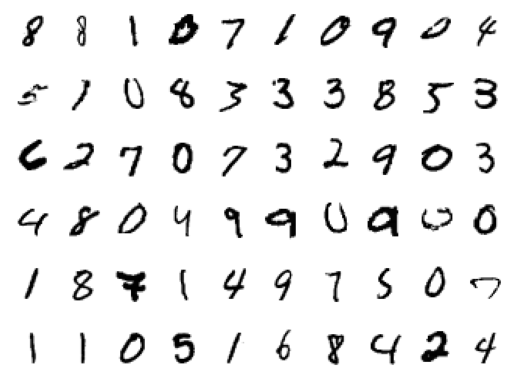

In [ ]:
mnist_data.showimages(num_of_images=60)

Model Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )  # output = 26x26, receptive field = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )  # output = 24x24, receptive field = 5x5 (each 3x3 kernel expands by 2)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )  # output = 22x22, receptive field = 7x7 (each 3x3 kernel expands by 2)

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)  # output = 11x11, receptive field = 14x14 (pooling doubles the receptive field)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )  # output = 11x11, receptive field = 14x14 (1x1 kernel doesn't change receptive field)

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )  # output = 9x9, receptive field = 16x16 (each 3x3 kernel expands by 2)

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        )  # output = 7x7, receptive field = 20x20 (each 3x3 kernel expands by 2)

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        )  # output = 7x7, receptive field = 20x20 (1x1 kernel doesn't change receptive field)

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        )  # output = 1x1x10, receptive field = 26x26 (7x7 kernel on 7x7 input results in 1x1 output covering the entire input)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


Model Summary

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             576
              ReLU-4            [-1, 8, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           1,152
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8            [-1, 8, 11, 11]             128
              ReLU-9            [-1, 8, 11, 11]               0
           Conv2d-10              [-1, 8, 9, 9]             576
             ReLU-11              [-1, 8, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           1,152
             ReLU-13             [-1, 16, 7, 7]               0
           Conv2d-14             [-1, 1

Training and testing our model

EPOCH: 0


Loss=0.47412967681884766 Batch_id=468 Accuracy=27.80: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]



Test set: Average loss: 0.4494, Accuracy: 8589/10000 (85.89%)

EPOCH: 1


Loss=0.11653430014848709 Batch_id=468 Accuracy=93.76: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]



Test set: Average loss: 0.0935, Accuracy: 9686/10000 (96.86%)

EPOCH: 2


Loss=0.12769411504268646 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]



Test set: Average loss: 0.0629, Accuracy: 9789/10000 (97.89%)

EPOCH: 3


Loss=0.02349969558417797 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]



Test set: Average loss: 0.0580, Accuracy: 9806/10000 (98.06%)

EPOCH: 4


Loss=0.05285802111029625 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]



Test set: Average loss: 0.0490, Accuracy: 9846/10000 (98.46%)

EPOCH: 5


Loss=0.0447750948369503 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:17<00:00, 27.02it/s]



Test set: Average loss: 0.0436, Accuracy: 9855/10000 (98.55%)

EPOCH: 6


Loss=0.03677144646644592 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]



Test set: Average loss: 0.0460, Accuracy: 9855/10000 (98.55%)

EPOCH: 7


Loss=0.014902535825967789 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:18<00:00, 25.66it/s]



Test set: Average loss: 0.0479, Accuracy: 9842/10000 (98.42%)

EPOCH: 8


Loss=0.010803557932376862 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]



Test set: Average loss: 0.0404, Accuracy: 9869/10000 (98.69%)

EPOCH: 9


Loss=0.03845849260687828 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:17<00:00, 26.98it/s]



Test set: Average loss: 0.0372, Accuracy: 9883/10000 (98.83%)

EPOCH: 10


Loss=0.0491597019135952 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0385, Accuracy: 9876/10000 (98.76%)

EPOCH: 11


Loss=0.015447375364601612 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0415, Accuracy: 9864/10000 (98.64%)

EPOCH: 12


Loss=0.028080983087420464 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]



Test set: Average loss: 0.0362, Accuracy: 9887/10000 (98.87%)

EPOCH: 13


Loss=0.10403967648744583 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]



Test set: Average loss: 0.0406, Accuracy: 9873/10000 (98.73%)

EPOCH: 14


Loss=0.02143152616918087 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]



Test set: Average loss: 0.0364, Accuracy: 9886/10000 (98.86%)



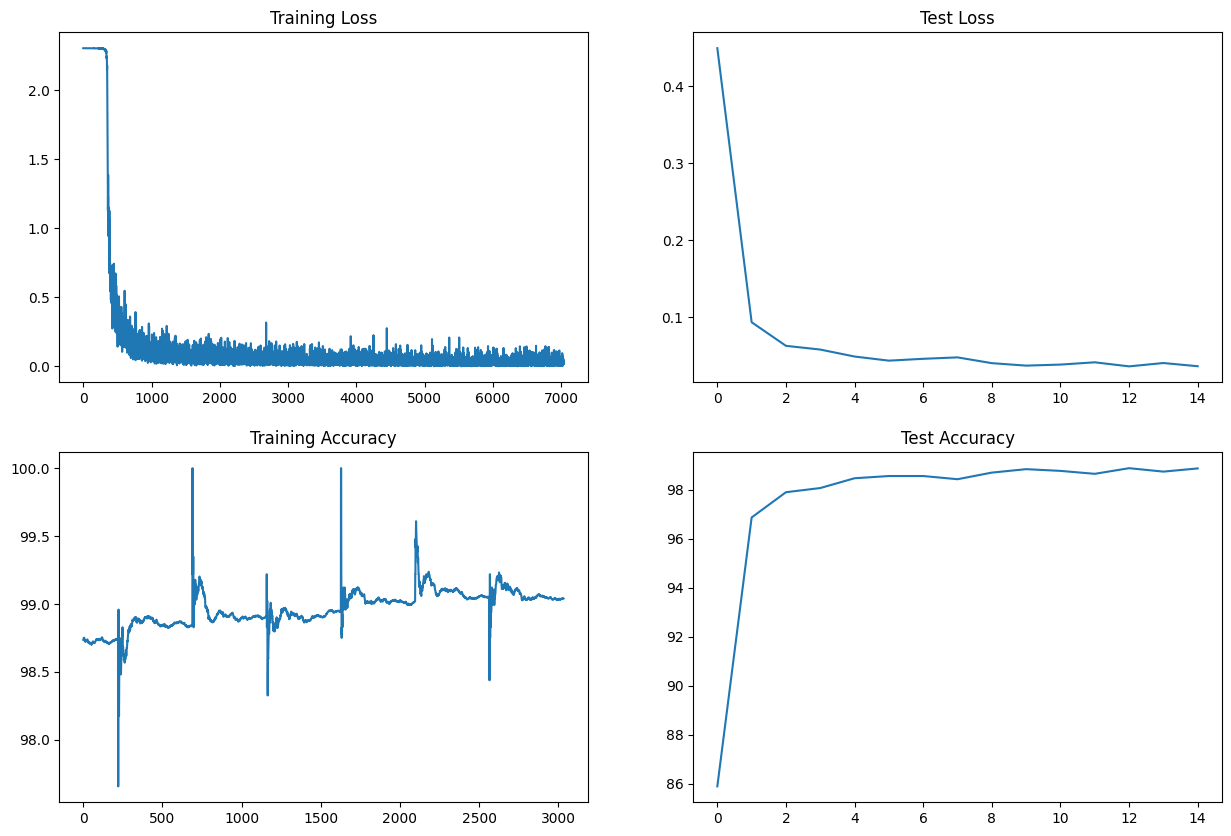

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model_fiteval = FitEvaluate(model, device,mnist_data.train_loader,mnist_data.test_loader)
model_fiteval.epoch_training(optimizer)


**Target:**

  Basic setup, transformers, data loader, training & test loop, lighter model

**Result:**

  Parameters: 8,716

  Best Training Accuracy: 99.04 %

  Best Test Accuracy: 98.87%

**Analysis:** The model is light & no overfitting.

Step-2 Batch Normalization, Regularization, Gap

Transformations on Data

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


Train & Test Data

In [ ]:
mnist_data = MNIST_DATA(train_transforms,test_transforms)

Loaded the MNIST data!!!


Data Statistics

In [ ]:
mnist_data.stats()

********* Train Data Stats *********
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


Visualizing Sample Images from the MNIST Dataset



 Batch Shape:  torch.Size([128, 1, 28, 28])
 Labels of the images:  torch.Size([128])
 Images


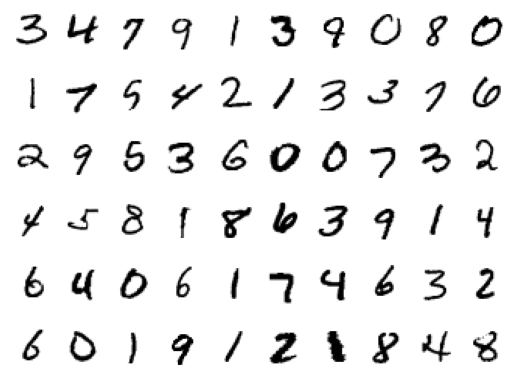

In [ ]:
mnist_data.showimages(num_of_images=60)

Model Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )  # output = 26x26, receptive field = 3x3 (since padding=0 and kernel_size=3x3)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )  # output = 24x24, receptive field = 5x5 (each 3x3 kernel expands the receptive field by 2)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )  # output = 22x22, receptive field = 7x7 (each 3x3 kernel expands the receptive field by 2)

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)  # output = 11x11, receptive field = 14x14 (pooling doubles the receptive field)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )  # output = 11x11, receptive field = 14x14 (1x1 kernel does not change the receptive field)

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )  # output = 9x9, receptive field = 16x16 (each 3x3 kernel expands the receptive field by 2)

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )  # output = 7x7, receptive field = 20x20 (each 3x3 kernel expands the receptive field by 2)

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )  # output = 7x7, receptive field = 20x20 (1x1 kernel does not change the receptive field)

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        )  # output_size = 1x1, receptive field = 26x26 (the global average pool covers the entire input)

        self.dropout = nn.Dropout(0.01)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.dropout(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


Model Summary

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
        MaxPool2d-12           [-1, 16, 11, 11]               0
          Dropout-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-1, 8,

Training and testing our model

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model_fiteval = FitEvaluate(model, device,mnist_data.train_loader,mnist_data.test_loader)
model_fiteval.epoch_training(optimizer)

NameError: name 'optim' is not defined


**Target:**

  Added batch normalization, regularization (dropout) and Gap(global average pooling) also removed the last big kernel

**Result:**

  Parameters: 3,964

  Best Training Accuracy: 98.45 %

  Best Test Accuracy: 98.67%

**Analysis:** The model is more lighter but the accuracies have reduced. This is sort of predicted given that the comparision is between a 8716 parameter model to 3964 parameter model.

Step -3 Increase capacity, Correct max pool and Image augumentation

Transformations on Data

In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                                      transforms.Resize((28, 28)),
                                      transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

Train & Test Data

In [7]:
mnist_data = MNIST_DATA(train_transforms,test_transforms)

Loaded the MNIST data!!!


Data Statistics

In [8]:
mnist_data.stats()

********* Train Data Stats *********
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(255.)
 - mean: tensor(33.3184)
 - std: tensor(78.5675)
 - var: tensor(6172.8506)


/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Visualizing Sample Images from the MNIST Dataset



 Batch Shape:  torch.Size([128, 1, 28, 28])
 Labels of the images:  torch.Size([128])
 Images


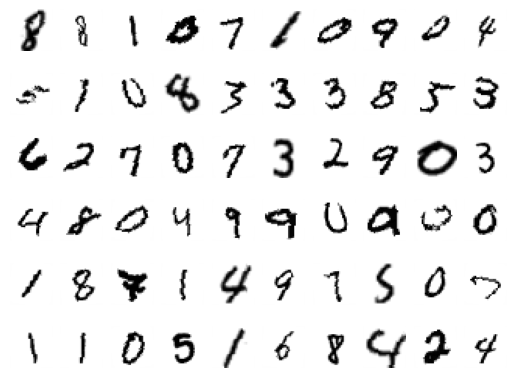

In [9]:
mnist_data.showimages(num_of_images=60)

Model Architecture

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            self.depthwise_separable_conv(1, 10, kernel_size=3, padding=1),  # output = 28x28, receptive field = 3x3
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False, dilation=2),  # output = 28x28, receptive field = 7x7
            nn.BatchNorm2d(10),
            nn.ReLU(),
            self.depthwise_separable_conv(10, 10, kernel_size=3, padding=1),  # output = 28x28, receptive field = 9x9
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False, dilation=2),  # output = 28x28, receptive field = 15x15
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05),
            self.depthwise_separable_conv(10, 10, kernel_size=3, padding=1),  # output = 28x28, receptive field = 17x17
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False, dilation=2),  # output = 28x28, receptive field = 23x23
            nn.BatchNorm2d(10),
            nn.ReLU(),
            self.depthwise_separable_conv(10, 13, kernel_size=3, padding=1),  # output = 28x28, receptive field = 25x25
            nn.BatchNorm2d(13),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # output = 14x14, receptive field = 50x50 (pooling doubles the receptive field)

        self.convblock2 = nn.Sequential(
            self.depthwise_separable_conv(13, 10, kernel_size=1, padding=0),  # output = 14x14, receptive field = 50x50
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False, dilation=2),  # output = 14x14, receptive field = 54x54
            nn.BatchNorm2d(10),
            nn.ReLU(),
            self.depthwise_separable_conv(10, 10, kernel_size=3, padding=1),  # output = 14x14, receptive field = 56x56
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False, dilation=2),  # output = 14x14, receptive field = 62x62
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05),
            self.depthwise_separable_conv(10, 13, kernel_size=3, padding=1),  # output = 14x14, receptive field = 64x64
            nn.BatchNorm2d(13),
            nn.ReLU(),
            nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 3), padding=1, bias=False, dilation=3),  # output = 14x14, receptive field = 70x70
            nn.BatchNorm2d(13),
            nn.ReLU(),
            self.depthwise_separable_conv(13, 13, kernel_size=3, padding=0),  # output = 14x14, receptive field = 72x72
            nn.BatchNorm2d(13),
            nn.ReLU(),
            self.depthwise_separable_conv(13, 10, kernel_size=1, padding=0)  # output = 14x14, receptive field = 72x72
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)  # output_size = 1x1
    def depthwise_separable_conv(self, in_channels, out_channels, kernel_size=3, padding=1):
        """Depthwise Separable Convolution (Depthwise + Pointwise)"""
        # Depthwise Convolution
        depthwise_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                   kernel_size=kernel_size, padding=padding, groups=in_channels,
                                   bias=False)

        # Pointwise Convolution (1x1)
        pointwise_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                    kernel_size=1, padding=0, bias=False)

        return nn.Sequential(depthwise_conv, pointwise_conv)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool1(x)
        x = self.convblock2(x)
        x = self.avgpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)



Model Summary


In [18]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 28, 28]               9
            Conv2d-2           [-1, 10, 28, 28]              10
       BatchNorm2d-3           [-1, 10, 28, 28]              20
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 26, 26]             900
       BatchNorm2d-6           [-1, 10, 26, 26]              20
              ReLU-7           [-1, 10, 26, 26]               0
            Conv2d-8           [-1, 10, 26, 26]              90
            Conv2d-9           [-1, 10, 26, 26]             100
      BatchNorm2d-10           [-1, 10, 26, 26]              20
             ReLU-11           [-1, 10, 26, 26]               0
           Conv2d-12           [-1, 10, 24, 24]             900
      BatchNorm2d-13           [-1, 10, 24, 24]              20
             ReLU-14           [-1, 10,

Training and testing our model

EPOCH: 0


Loss=2.328530788421631 Batch_id=0 Accuracy=11.72:   0%|          | 1/469 [00:00<02:25,  3.21it/s]

Loss=0.11466807872056961 Batch_id=468 Accuracy=86.64: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s] 



Test set: Average loss: 0.0758, Accuracy: 9766/10000 (97.66%)

EPOCH: 1


Loss=0.06194372475147247 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s] 



Test set: Average loss: 0.0499, Accuracy: 9839/10000 (98.39%)

EPOCH: 2


Loss=0.06194883957505226 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s] 



Test set: Average loss: 0.0419, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.02914474345743656 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s] 



Test set: Average loss: 0.0393, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


Loss=0.19378453493118286 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s] 



Test set: Average loss: 0.0324, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.03307361528277397 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]  



Test set: Average loss: 0.0224, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.03563600406050682 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]  



Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.0021241807844489813 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]



Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.021718481555581093 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s] 



Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.0335807166993618 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]   



Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.03925560414791107 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]  



Test set: Average loss: 0.0180, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.009178793989121914 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s] 



Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.04325735569000244 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]  



Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.02544298768043518 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]  



Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.006964782252907753 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s] 



Test set: Average loss: 0.0180, Accuracy: 9940/10000 (99.40%)



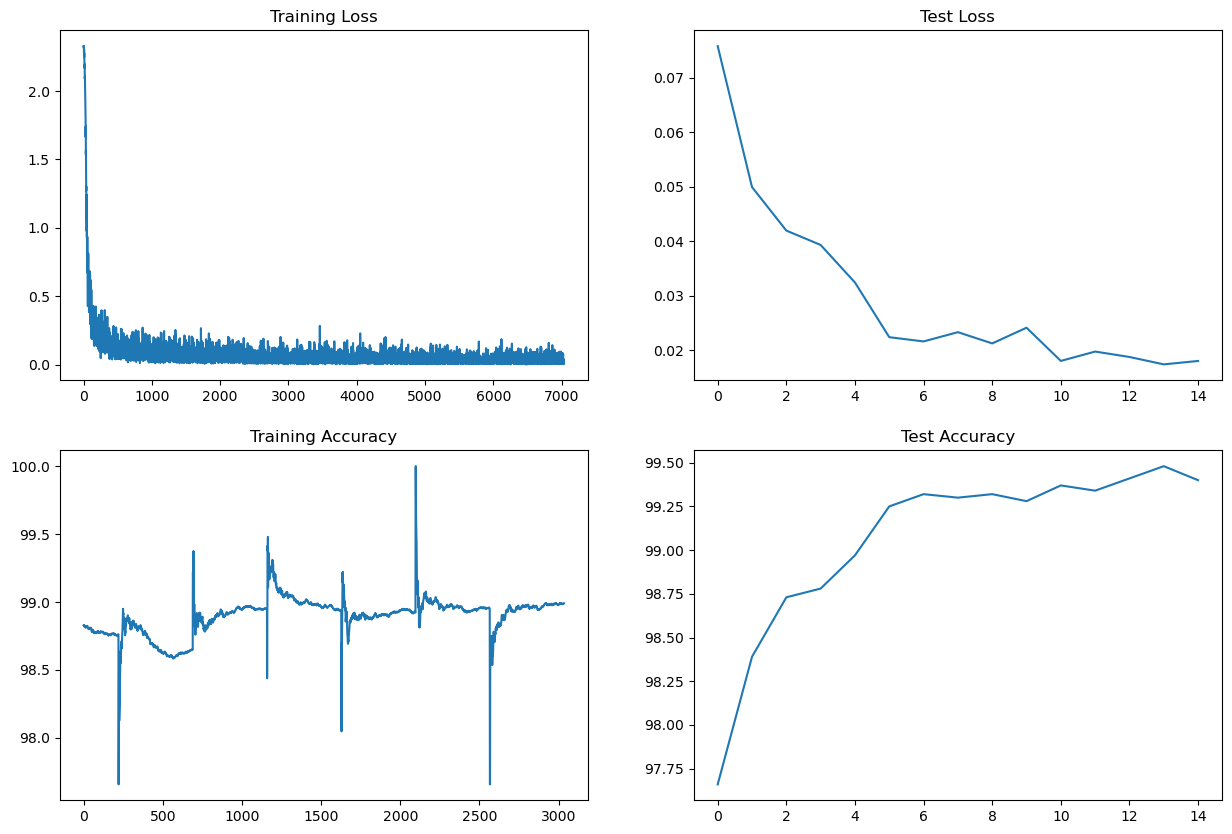

In [19]:
from torch.optim.lr_scheduler import StepLR
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.4)

model_fiteval = FitEvaluate(model, device,mnist_data.train_loader,mnist_data.test_loader)
model_fiteval.epoch_training(optimizer, scheduler = scheduler)


**Target:**

Applied a random rotation of 7 degrees on training sample, added one more layer after GAP and set up a learning rate scheduler.

**Result:**

  Parameters: 6,280

  Best Training Accuracy: 99.38 %

  Best Test Accuracy: 99.47%

**Analysis:** The model is slightly heavier as compared to model 2.The CNN model was successfully trained to predict digits from the MNIST dataset with fewer than 8k parameters, achieving a consistent accuracy of at least 99.4% in under 15 epochs, while minimizing the gap between training and test accuracy.